In [1]:
%matplotlib notebook
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [3]:
import gymnasium as gym
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import datetime
import random
import torch.distributions as dist


import sys
sys.path.append("..")
from replay_buffer import ReplayBuffer

In [3]:
# %matplotlib qt5

## 自适应最大熵系数SAC

In [47]:

class Actor(nn.Module):

    def __init__(self, n_state, n_action, n_hidden=64):
        super(Actor, self).__init__()
        
        self.fc1 = nn.Linear(n_state, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.fc_mean = nn.Linear(n_hidden, n_action)
        self.fc_std = nn.Linear(n_hidden, n_action)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mu = self.fc_mean(x)
        std = F.softplus(self.fc_std(x)) + 1e-6

        normal_dist = torch.distributions.Normal(mu, std)
        sample = normal_dist.rsample()
        log_prob = normal_dist.log_prob(sample)
        
        # 
        action = torch.tanh(sample) 
        log_prob = log_prob - torch.log(1 - action.pow(2) + 1e-6)
        return action*2, log_prob

class Critic(nn.Module):

    def __init__(self, n_state, n_action, n_hidden=64):
        super(Critic, self).__init__()
        
        self.fc1 = nn.Linear(n_state + n_action, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.fc3 = nn.Linear(n_hidden, 1)
    
    def forward(self, state, action):
        x = F.relu(self.fc1(torch.cat([state, action], dim=1)))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class SacAdaptive(nn.Module):

    def __init__(self, n_state, n_action, n_hidden=64, lr_actor=3e-4, lr_critic=3e-3, target_entropy=-1, gamma=0.99, tau = 0.02):
        super(SacAdaptive, self).__init__()
        self.device = "cpu"
        
        self.actor = Actor(n_state, n_action, n_hidden).to(self.device)
        self.actor_opt = torch.optim.Adam(self.actor.parameters(), lr=lr_actor)
        
        self.c1 = Critic(n_state, n_action, n_hidden).to(self.device)
        self.c1_target = Critic(n_state, n_action, n_hidden).to(self.device)
        self.c1_target.load_state_dict(self.c1.state_dict())
        self.c1_opt = torch.optim.Adam(self.c1.parameters(), lr=lr_critic)
        
        self.c2 = Critic(n_state, n_action, n_hidden).to(self.device)
        self.c2_target = Critic(n_state, n_action, n_hidden).to(self.device)
        self.c2_target.load_state_dict(self.c2.state_dict())
        self.c2_opt = torch.optim.Adam(self.c2.parameters(), lr=lr_critic)
        
        self.target_entropy = target_entropy
        self.log_alpha = torch.tensor(np.log(0.01), dtype=torch.float, requires_grad=True)
        self.alpha_opt = torch.optim.Adam([self.log_alpha], lr=3e-4)
        
        
        self.tau = tau
        self.gamma = gamma
        
        self.init_params = {
            "n_state": n_state,
            "n_action": n_action,
            "n_hidden": n_hidden,
            "lr_actor": lr_actor,
            "lr_critic": lr_critic,
            "target_entropy": target_entropy,
            "gamma": gamma,
            "tau": tau
        }

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        action, _ = self.actor(state)
        # print("==============:", action[0])
        return [action.item()]
    
    def compute_critic_target(self, reward, next_state, done):
        next_action, log_prob = self.actor(next_state)
        entropy = -log_prob
        
        q1_value = self.c1_target(next_state, next_action)
        q2_value = self.c2_target(next_state, next_action)
        next_value = torch.min(q1_value, q2_value) + self.log_alpha.exp() * entropy
        td_target = reward + (1 - done) * self.gamma * next_value
        return td_target
    
    def soft_update(self, net, target_net):
        for param, target_param in zip(net.parameters(), target_net.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
        
    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)
        
        # critic网络训练
        td_target = self.compute_critic_target(rewards, next_states, dones)
        
        q1_loss = torch.mean(F.mse_loss(self.c1(states, actions), td_target.detach()))
        self.c1_opt.zero_grad()
        q1_loss.backward()
        self.c1_opt.step()
        
        q2_loss = torch.mean(F.mse_loss(self.c2(states, actions), td_target.detach()))
        self.c2_opt.zero_grad()
        q2_loss.backward()
        self.c2_opt.step()
        
        # actor网络训练
        new_actions, log_prob = self.actor(states)
        # print("=================new_actions:", new_actions)
        entropy = -log_prob
        q1_value = self.c1(states, new_actions)
        q2_value = self.c2(states, new_actions)
        actor_loss = torch.mean(-self.log_alpha.exp() * entropy - torch.min(q1_value, q2_value))
        self.actor_opt.zero_grad()
        actor_loss.backward()
        self.actor_opt.step()
        
        # target critic网络软更新
        self.soft_update(self.c1, self.c1_target)
        self.soft_update(self.c2, self.c2_target)
        
        # alpha更新
        alpha_loss = -torch.mean(self.log_alpha * (-entropy + self.target_entropy).detach())
        self.alpha_opt.zero_grad()
        alpha_loss.backward()
        self.alpha_opt.step()
        
        return actor_loss.detach().item(), q1_loss.detach().item(), q2_loss.detach().item(), entropy.mean().detach().item()
        
    
    @staticmethod
    def save_model(model, filename):
        torch.save({"init_params": model.init_params, "state_dict": model.state_dict()}, filename)
    
    @staticmethod
    def load_model(filename):
        checkpoint = torch.load(filename)
        model = SacAdaptive(**checkpoint["init_params"])
        model.load_state_dict(checkpoint["state_dict"])
        return model

## SAC训练

In [25]:
def train_off_policy_agent(env, agent, num_episodes, rb, batch_size=64):
    return_list = []
    episode_return = 0

    actor_list = []
    q1_list = []
    q2_list = []
    alpha_list = []

    for epoch in range(num_episodes//10):
    
        for i in tqdm(range(10), position=0, desc=f"###{epoch} : {episode_return}, rb:{len(rb)} "):
            episode_return = 0
            state, _ = env.reset(seed=0)
            done , truncated = False, False
            while not done and not truncated:
                action = agent.take_action(state)
                next_state, reward, done, truncated, info = env.step(action)
                done = done or truncated
                rb.push(state, action, reward, next_state, done)

                if len(rb) > 100:
                    batch_samples = rb.sample(batch_size)
                    transition_dict = {
                        "states": [x[0] for x in batch_samples],
                        "actions": [x[1] for x in batch_samples],
                        "rewards": [x[2] for x in batch_samples],
                        "next_states": [x[3] for x in batch_samples],
                        "dones": [x[4] for x in batch_samples],
                    }
                    al, q1l, q2l, alpha = agent.update(transition_dict)

                    actor_list.append(al)
                    q1_list.append(q1l)
                    q2_list.append(q2l)
                    alpha_list.append(alpha)
                    
                
                state = next_state
                episode_return += reward
            return_list.append(episode_return)
    fig, ax = plt.subplots(3,1, figsize=(12,8))
    ax[0].plot(actor_list)
    ax[1].plot(q1_list)
    ax[1].plot(q2_list)
    ax[2].plot(alpha_list)
    # ax[2].set_ylim(-1,1)
    plt.show()
    
    return return_list



def test_agent(agent, env_name):
    %matplotlib qt5

    env = gym.make(env_name, render_mode="human")

    state, info = env.reset(seed=0)

    print(f"Starting observation: {state}")

    episode_over = False
    total_reward = 0
    action_list = []

    while not episode_over:
        action = agent.take_action(state)
        state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        episode_over = terminated or truncated
        # print(f"{action=}")
        action_list.append(action)

    print(f"Episode finished! Total reward: {total_reward}")
    env.close()
    return action_list
    

# action_list = test_agent(agent, env_name)

# %matplotlib inline
# plt.hist(action_list, bins=30, density=True, alpha=0.7)
# plt.show()

## MountainCarContinuous-v0

state space: [-0.356372    0.02117792]
action space: Box(-1.0, 1.0, (1,), float32)
action bound: 1.0
target_entropy: -0.25


###0 : 0, rb:0 :   0%|          | 0/10 [00:00<?, ?it/s]

###1 : -0.8985553485406831, rb:9990 :   0%|          | 0/10 [00:00<?, ?it/s]

###2 : -0.8085565875503573, rb:19980 :   0%|          | 0/10 [00:00<?, ?it/s]

###3 : -0.8190566921915252, rb:29970 :   0%|          | 0/10 [00:00<?, ?it/s]

###4 : -0.8100399429659895, rb:39960 :   0%|          | 0/10 [00:00<?, ?it/s]

###5 : -0.798626091102928, rb:49950 :   0%|          | 0/10 [00:00<?, ?it/s]

###6 : -0.847748999946837, rb:59940 :   0%|          | 0/10 [00:00<?, ?it/s]

###7 : -0.7584340103667551, rb:69930 :   0%|          | 0/10 [00:00<?, ?it/s]

###8 : -0.7708767047536186, rb:79920 :   0%|          | 0/10 [00:00<?, ?it/s]

###9 : -0.8163794069728306, rb:89910 :   0%|          | 0/10 [00:00<?, ?it/s]

###10 : -0.8557363832783289, rb:99900 :   0%|          | 0/10 [00:00<?, ?it/s]

###11 : -0.8162819586702847, rb:100000 :   0%|          | 0/10 [00:00<?, ?it/s]

###12 : -0.8505285701751166, rb:100000 :   0%|          | 0/10 [00:00<?, ?it/s]

###13 : -0.8390481532775128, rb:100000 :   0%|          | 0/10 [00:00<?, ?it/s]

###14 : -0.7936192341178456, rb:100000 :   0%|          | 0/10 [00:00<?, ?it/s]

###15 : -0.8116778747428433, rb:100000 :   0%|          | 0/10 [00:00<?, ?it/s]

###16 : -0.8133287251481447, rb:100000 :   0%|          | 0/10 [00:00<?, ?it/s]

###17 : -0.8336949906771651, rb:100000 :   0%|          | 0/10 [00:00<?, ?it/s]

###18 : -0.6978627922737688, rb:100000 :   0%|          | 0/10 [00:00<?, ?it/s]

###19 : -0.7891150264679775, rb:100000 :   0%|          | 0/10 [00:00<?, ?it/s]

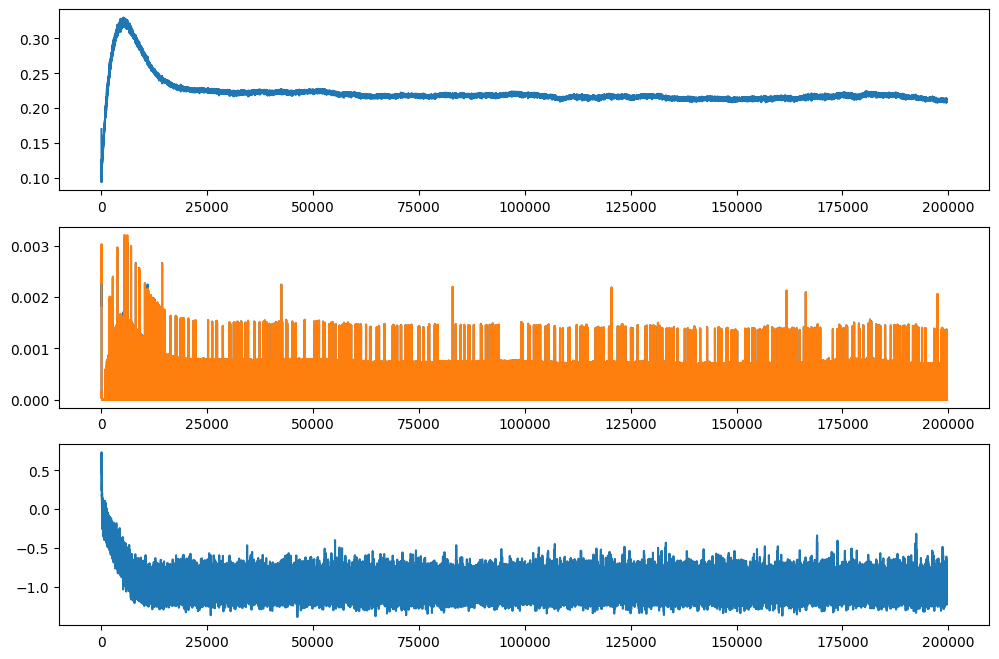

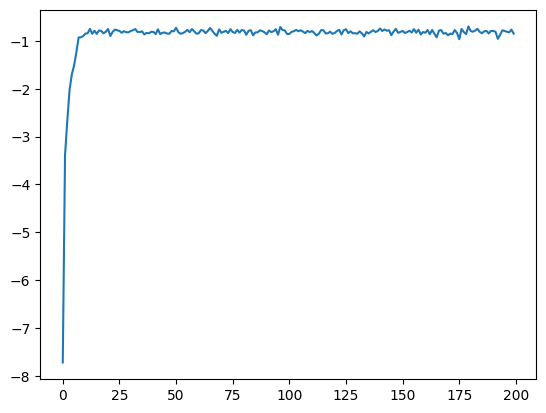

In [46]:

num_episodes = 200

device = "cpu"
env_name = "MountainCarContinuous-v0"
# env_name = "Pendulum-v1"

env = gym.make(env_name)
# torch.manual_seed(0)
# random.seed(0)
# np.random.seed(0)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]
target_entropy = -env.action_space.shape[0]/4

print(f"state space:" , env.observation_space.sample())
print(f"action space: {env.action_space}")
print(f"action bound: {action_bound}")
print(f"target_entropy: {target_entropy}")


agent = SacAdaptive(n_state=state_dim, n_action=action_dim, n_hidden=64)

replay_buffer = ReplayBuffer(capacity=100000)
return_list = train_off_policy_agent(env, agent, num_episodes,replay_buffer)

%matplotlib inline
plt.plot(return_list)
plt.show()

In [38]:
action_list = test_agent(agent, env_name)

Starting observation: [-0.47260767  0.        ]
Episode finished! Total reward: -0.8950343045850316


## Pendulum

state space: [-0.16699901 -0.9839625  -6.4482346 ]
action space: Box(-2.0, 2.0, (1,), float32)
action bound: 2.0


###0 : 0, rb:0 :   0%|          | 0/10 [00:00<?, ?it/s]

###1 : -1429.2794012285751, rb:2000 :   0%|          | 0/10 [00:00<?, ?it/s]

###2 : -871.6386142922111, rb:4000 :   0%|          | 0/10 [00:00<?, ?it/s]

###3 : -384.1277055120476, rb:6000 :   0%|          | 0/10 [00:00<?, ?it/s]

###4 : -128.59308470106618, rb:8000 :   0%|          | 0/10 [00:00<?, ?it/s]

###5 : -126.28001801652125, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###6 : -126.8176357149494, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###7 : -128.15963882207433, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###8 : -128.08043981028254, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###9 : -130.66126580221697, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###10 : -130.30290429970586, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###11 : -127.55496853858894, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###12 : -126.76743504629732, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###13 : -127.57806367641066, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###14 : -129.24628782199872, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###15 : -127.24211501596018, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###16 : -127.53615313766672, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###17 : -126.72116028891489, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###18 : -128.36043625631316, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###19 : -129.99801840599244, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###20 : -126.34847864284144, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###21 : -128.54847641095068, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###22 : -128.7362501324876, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###23 : -128.32695551794902, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###24 : -127.26408015551196, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###25 : -127.25725555299019, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###26 : -128.09789946014064, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###27 : -128.23400936783065, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###28 : -126.47761714104516, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###29 : -127.05309568465017, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###30 : -127.10167004897339, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###31 : -128.74646265550726, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###32 : -128.61791235673533, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###33 : -128.32591654344304, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###34 : -128.09075731779484, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###35 : -128.0797912469449, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###36 : -127.38833256960302, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###37 : -127.896442834275, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###38 : -128.14934522942377, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###39 : -127.8099314404032, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###40 : -128.2759158342976, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###41 : -128.0386053148859, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###42 : -128.19066183805305, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###43 : -129.11053116315924, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###44 : -128.19816607110812, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###45 : -127.51563615186357, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###46 : -128.1529547047517, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###47 : -127.38327960547954, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###48 : -128.37222961950746, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###49 : -127.4726333809234, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

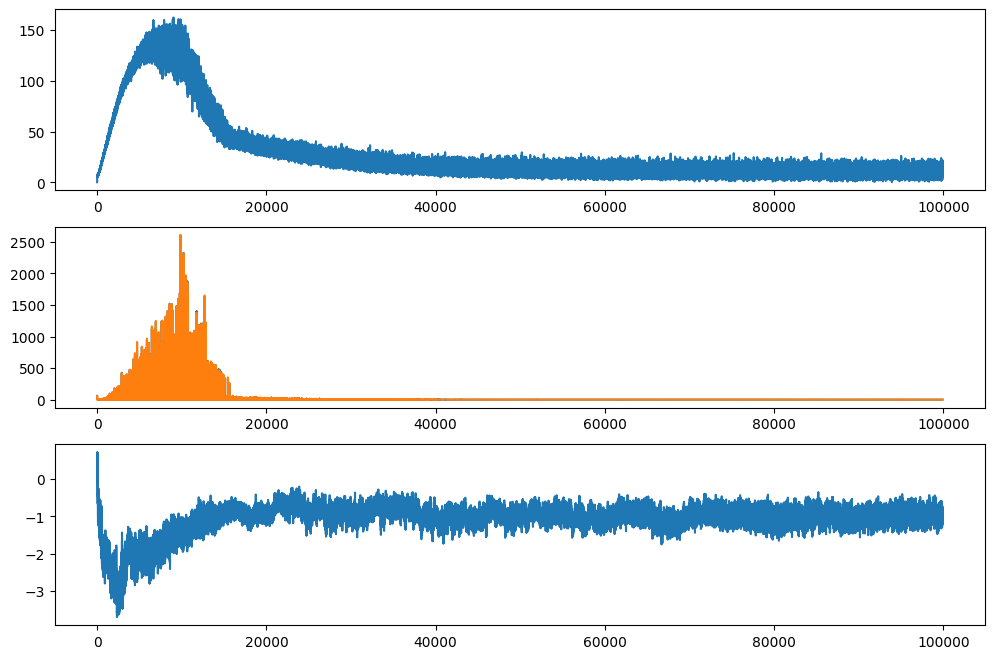

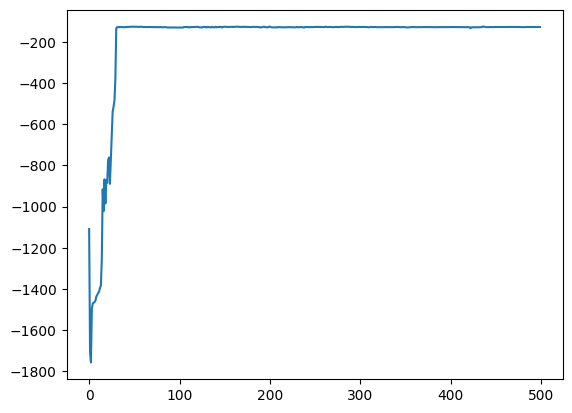

Starting observation: [ 0.6520163   0.758205   -0.46042657]
Episode finished! Total reward: -128.61673835381123


In [48]:
actor_lr = 1e-4
critic_lr = 1e-3
num_episodes = 500

device = "cpu"
env_name = "Pendulum-v1"

env = gym.make(env_name)
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]
target_entropy = -env.action_space.shape[0]


print(f"state space:" , env.observation_space.sample())
print(f"action space: {env.action_space}")
print(f"action bound: {action_bound}")

agent = SacAdaptive(n_state=state_dim, n_action=action_dim, n_hidden=64, tau=0.005,gamma=0.99)

replay_buffer = ReplayBuffer(capacity=10000)
return_list = train_off_policy_agent(env, agent, num_episodes,replay_buffer)

%matplotlib inline
plt.plot(return_list)
plt.show()

action_list = test_agent(agent, env_name)